In [1]:

import tensorflow as tf

gpu_devices = tf.config.experimental.list_physical_devices('GPU')

if gpu_devices:
    tf.config.experimental.set_visible_devices(gpu_devices[1], 'GPU')
    print(gpu_devices[1])
    print('Success')



PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
Success


In [2]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

In [3]:
# Path to your dataset
data_dir = '../Data/bone_marrow_cell_dataset'

# List to store image paths and labels
image_paths = []
labels = []

# Loop through class directories

for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    
    if os.path.isdir(class_dir):
        for sub_dir_name in os.listdir(class_dir):
            sub_dir_path = os.path.join(class_dir, sub_dir_name)
            
            if os.path.isdir(sub_dir_path):
                for img_name in tqdm(os.listdir(sub_dir_path), desc=f"Processing {class_name}/{sub_dir_name}"):
                    img_path = os.path.join(sub_dir_path, img_name)
                    if os.path.isfile(img_path):
                        image_paths.append(img_path)
                        labels.append(class_name)
            else:
                img_path = os.path.join(class_dir, sub_dir_name)
                if os.path.isfile(img_path):
                    image_paths.append(img_path)
                    labels.append(class_name)
    else:
        img_path = class_dir  # For classes without subdirectories
        if os.path.isfile(img_path):
            image_paths.append(img_path)
            labels.append(class_name)

Processing LYT/13001-14000: 100%|██████████| 1000/1000 [00:00<00:00, 171890.66it/s]


Processing EBO/24001-25000: 100%|██████████| 1000/1000 [00:00<00:00, 100407.06it/s]


In [4]:
# Splitting the data into train, test, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(image_paths, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Now X_train, y_train, X_val, y_val, X_test, y_test are the organized data for training, validation, and testing
# Combine all labels from train, validation, and test sets
combined_labels = y_train + y_val + y_test

# Print all unique classes
unique_classes = set(combined_labels)
print("Unique classes:", unique_classes)

Unique classes: {'KSC', 'OTH', 'NGS', 'PMO', 'ABE', 'NGB', 'LYI', 'PEB', 'LYT', 'MYB', 'EBO', 'FGC', 'BAS', 'EOS', 'NIF', 'MON', 'PLM', 'HAC', 'MMZ', 'BLA', 'ART'}


In [5]:
from sklearn.preprocessing import LabelEncoder

# Convert string labels to numerical labels using LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Calculate the number of classes directly from the labels
num_classes = len(set(combined_labels))

# Convert numerical labels to one-hot encoded vectors
y_train_onehot = to_categorical(y_train_encoded, num_classes)
y_val_onehot = to_categorical(y_val_encoded, num_classes)
y_test_onehot = to_categorical(y_test_encoded, num_classes)

num_classes


21

In [6]:
# Change the input shape to match DenseNet121's input shape
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(250, 250, 3))

# Add custom layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)


2024-02-14 03:45:39.869650: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22118 MB memory:  -> device: 1, name: NVIDIA RTX A5000, pci bus id: 0000:af:00.0, compute capability: 8.6


In [7]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 125, 125, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 125, 125, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [9]:
# Preprocess images using ImageDataGenerator
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  
    rescale=1. / 255
)


batch_size = 32

# Define a custom generator to load and preprocess images on-the-fly
def custom_generator(image_paths, labels, batch_size):
    num_samples = len(image_paths)
    while True:
        indices = np.random.choice(num_samples, size=batch_size, replace=False)
        batch_images = []
        batch_labels = []
        for idx in indices:
            img_path = image_paths[idx]
            label = labels[idx]
            try:
                img = load_img(img_path, target_size=(250, 250))  # Resize images to VGG-16 input size
                img_array = img_to_array(img)
                batch_images.append(img_array)
                batch_labels.append(label)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
        yield np.array(batch_images), to_categorical(label_encoder.transform(batch_labels), num_classes)

In [10]:

filepath = 'DenseNet121_weights.hdf5'
callbacks_list = [EarlyStopping(monitor='val_accuracy', patience=10, verbose=1),
                  ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'),
                  ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=1)]

In [11]:
# Create custom generators for training, validation, and test sets
train_generator = custom_generator(X_train, y_train, batch_size)
val_generator = custom_generator(X_val, y_val, batch_size)
test_generator = custom_generator(X_test, y_test, batch_size)


In [12]:
epochs = 10

# Train the model using the custom generator
model.fit(
    custom_generator(X_train, y_train, batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=custom_generator(X_val, y_val, batch_size),
    validation_steps=len(X_val) // batch_size,
    verbose=1,
    callbacks=callbacks_list
)

2024-02-14 03:45:46.445037: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2024-02-14 03:46:13.866777: I tensorflow/stream_executor/cuda/cuda_dnn.cc:381] Loaded cuDNN version 8204
2024-02-14 03:46:19.189693: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3748/3748 [==============================] - 1139s 294ms/step - loss: 2.1275 - accuracy: 0.3358 - val_loss: 2.0003 - val_accuracy: 0.4148

Epoch 00001: val_accuracy improved from -inf to 0.41477, saving model to DenseNet121_weights.hdf5
Epoch 2/10
3748/3748 [==============================] - 1090s 291ms/step - loss: 1.7515 - accuracy: 0.4508 - val_loss: 2.7508 - val_accuracy: 0.0934

Epoch 00002: val_accuracy did not improve from 0.41477
Epoch 3/10
3748/3748 [==============================] - 1090s 291ms/step - loss: 1.6215 - accuracy: 0.4965 - val_loss: 2.2759 - val_accuracy: 0.2810

Epoch 00003: val_accuracy did not improve from 0.41477
Epoch 4/10
3748/3748 [==============================] - 1120s 299ms/step - loss: 1.4957 - accuracy: 0.5406 - val_loss: 1.3982 - val_accuracy: 0.5510

Epoch 00004: val_accuracy improved from 0.41477 to 0.55102, saving model to DenseNet121_weights.hdf5
Epoch 5/10
3748/3748 [==============================] - 1091s 291ms/step - loss: 1.3838 - accuracy: 0.

In [13]:
model.save('DenseNet121_Model.h5')

In [14]:
model_final = load_model('DenseNet121_weights.hdf5')

In [15]:
# Evaluate the model on the test set using the custom generator
test_loss, test_accuracy = model_final.evaluate(
    test_generator,
    steps=len(X_test) // batch_size,
    verbose=1,
)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')



803/803 [==============================] - 153s 186ms/step - loss: 0.9163 - accuracy: 0.7178
Test Loss: 0.9163
Test Accuracy: 0.7178


In [16]:

# Determine the size of the test dataset
test_size = len(X_test)

print("Total number of samples in the test dataset:", test_size)


Total number of samples in the test dataset: 25707


In [17]:

from math import ceil
from sklearn.metrics import classification_report

# Determine the size of the test dataset
test_size = len(X_test)

# Calculate the number of steps based on batch size
batch_size = 32  # Adjust according to your generator's batch size
test_steps = ceil(test_size / batch_size)

# Initialize empty lists to store true and predicted labels
y_true = []
y_pred = []

# Iterate through the test generator to obtain predictions batch-wise
for i in range(test_steps):
    x_batch, y_batch = next(test_generator)
    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(model_final.predict(x_batch), axis=1))



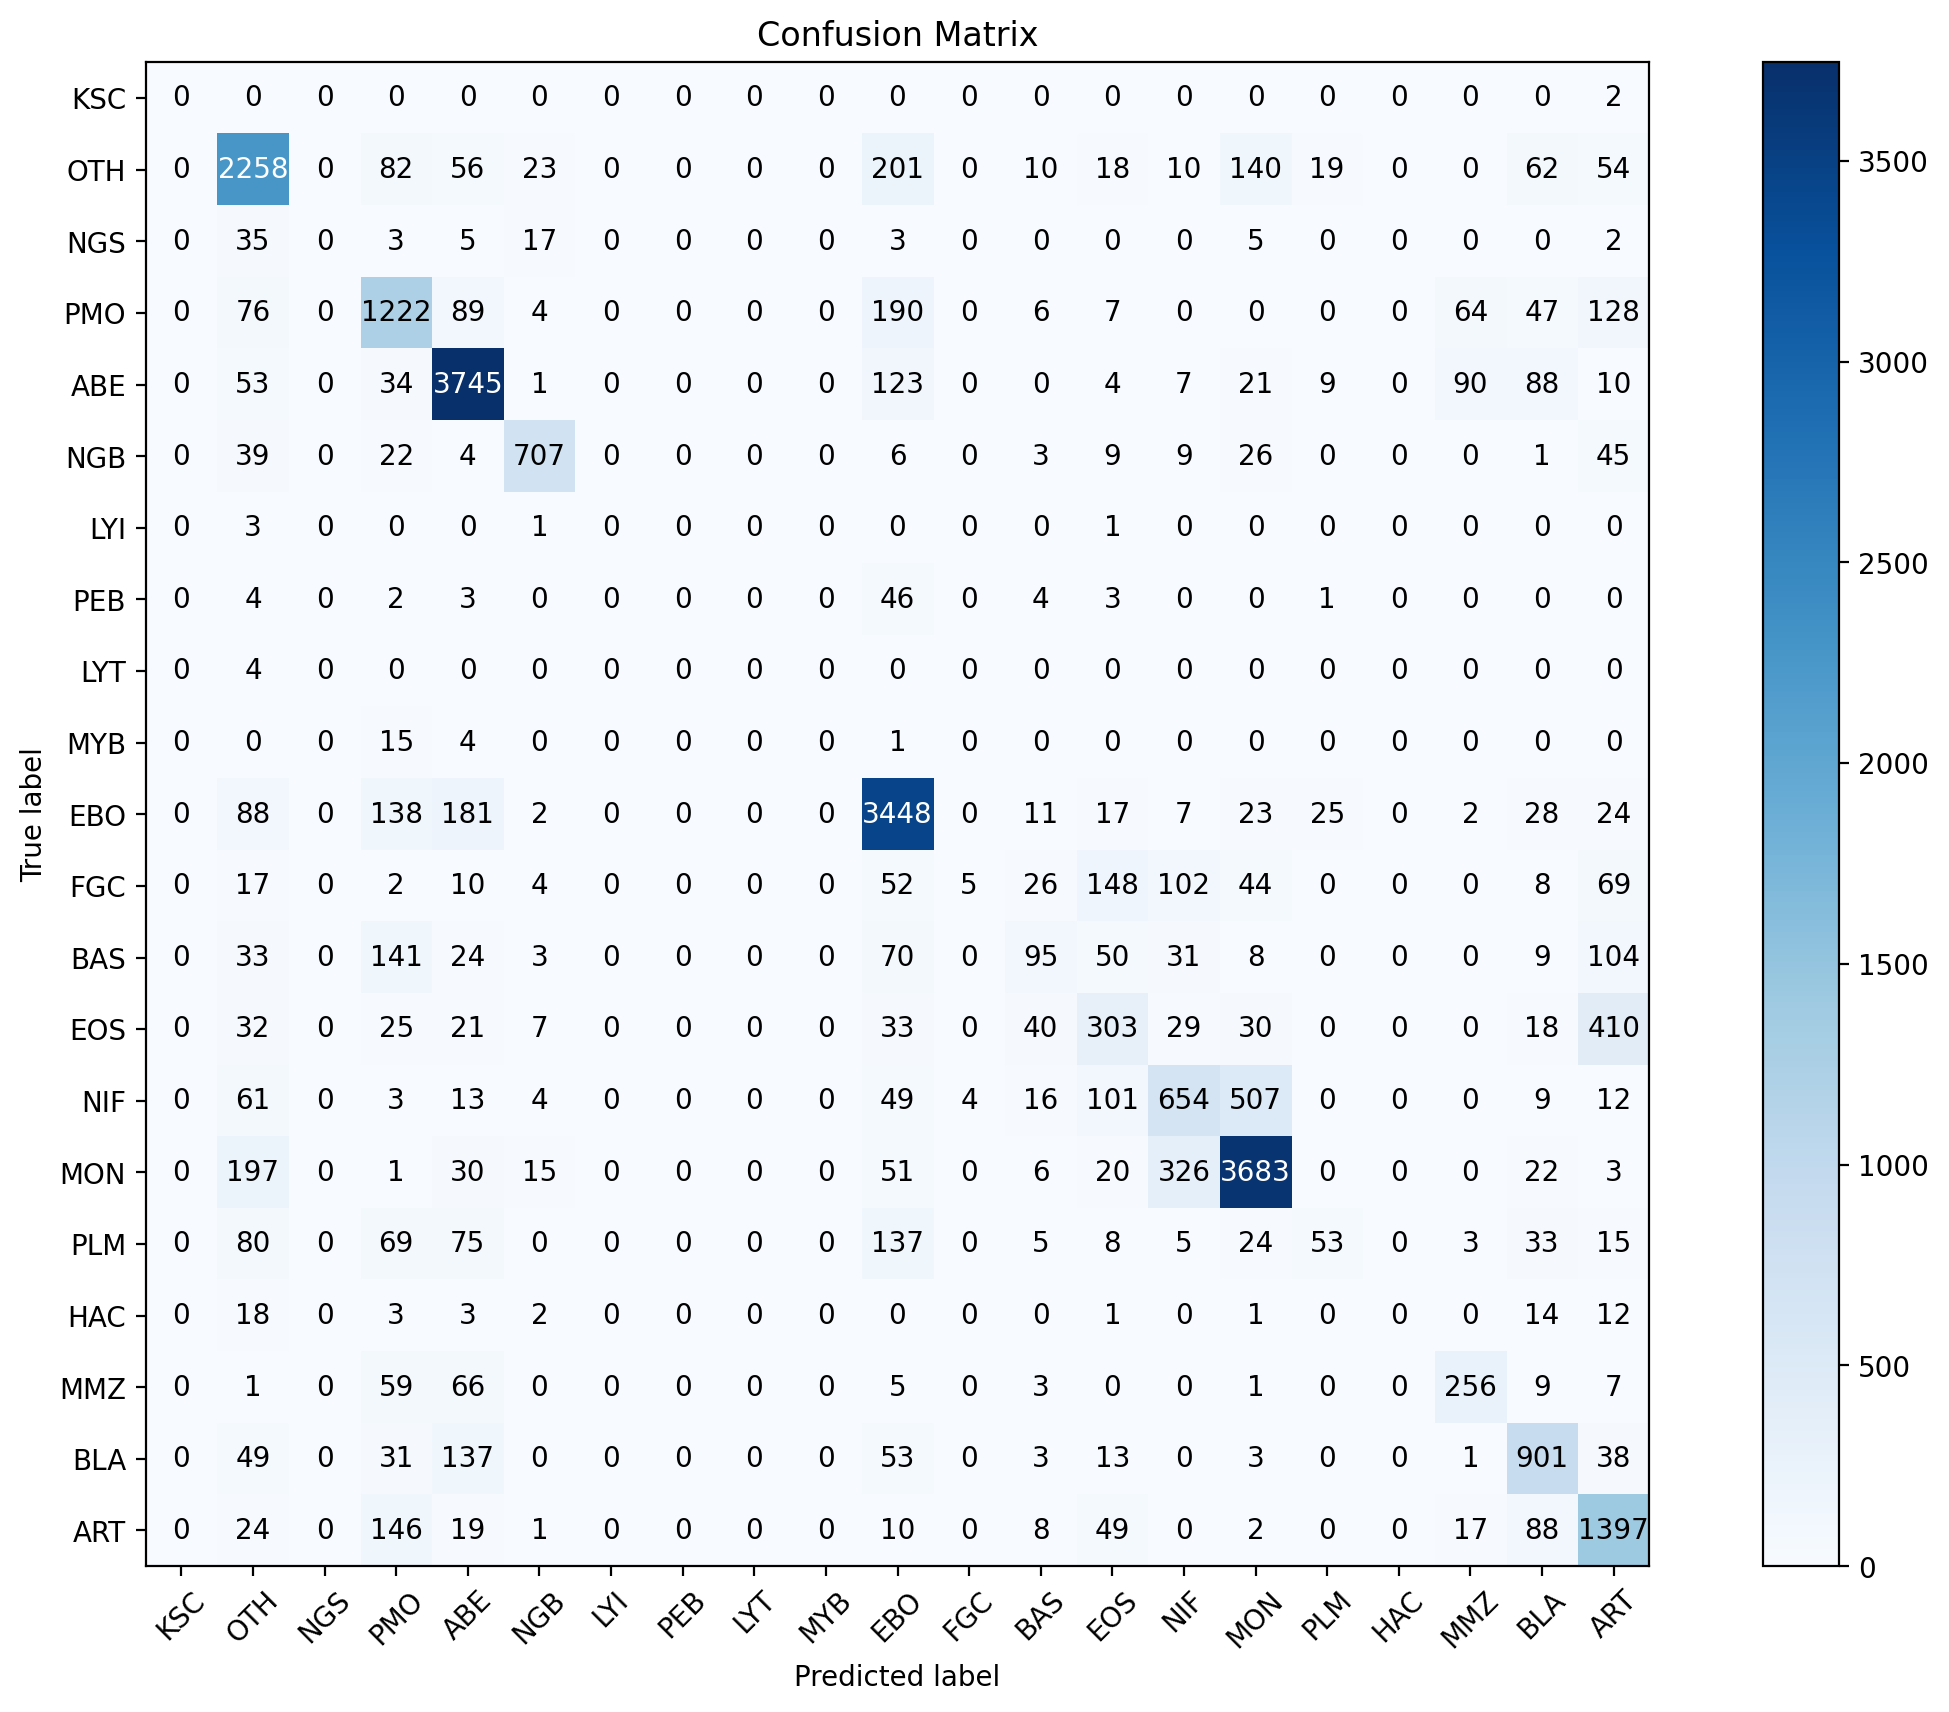

Classification Report:
              precision    recall  f1-score   support

         KSC       0.00      0.00      0.00         2
         OTH       0.74      0.77      0.75      2933
         NGS       0.00      0.00      0.00        70
         PMO       0.61      0.67      0.64      1833
         ABE       0.84      0.89      0.86      4185
         NGB       0.89      0.81      0.85       871
         LYI       0.00      0.00      0.00         5
         PEB       0.00      0.00      0.00        63
         LYT       0.00      0.00      0.00         4
         MYB       0.00      0.00      0.00        20
         EBO       0.77      0.86      0.81      3994
         FGC       0.56      0.01      0.02       487
         BAS       0.40      0.17      0.24       568
         EOS       0.40      0.32      0.36       948
         NIF       0.55      0.46      0.50      1433
         MON       0.82      0.85      0.83      4354
         PLM       0.50      0.10      0.17       507
    

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Get the list of all possible classes
all_classes = sorted(set(y_true + y_pred + y_train_encoded.tolist()))

# Calculate confusion matrix with all classes
conf_matrix = confusion_matrix(y_true, y_pred, labels=all_classes)

# Plot confusion matrix
plt.figure(figsize=(11.7, 8.27), dpi=200)
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(all_classes))

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, conf_matrix[i, j],
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(tick_marks, unique_classes, rotation=45)
plt.yticks(tick_marks, unique_classes)
plt.savefig('DenseNet121.png')
plt.show()

# Calculate classification report
class_report = classification_report(y_true, y_pred,target_names=unique_classes)

# Print classification report
print("Classification Report:")
print(class_report)
